In [131]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [139]:
import pandas as pd
import matplotlib as plt
#url="https://snow.ucsb.edu/index.php/level-2-model-ready/sesame2011to2017_AirTemp_RH_SnowDepth_SWE.csv"
#test = pd.read_csv(url)

In [122]:
data_rh =  pd.read_csv('/Users/carina/Desktop/code/whw2019_snow_modeling/sesame2011to2017_AirTemp_RH_SnowDepth_SWE.csv')
data_air_p = pd.read_csv('/Users/carina/Desktop/code/whw2019_snow_modeling/cues2011to2017_Radiation_Albedo_WindSpeed_GroundTemp_AirTemp_RH_AirPressure_SnowDepth_SWE.csv')
data_air_p

,DateTime,uplooking_broadband_watts_per_meterxx2,uplooking_direct_watts_per_meterxx2,uplooking_diffuse_watts_per_meterxx2,uplooking_src,direct_broadband_snow_albedo,uplooking_longwave_watts_per_meterxx2,uplooking_longwave_src,wind_speed_meters_per_sec,wind_dir_deg,...,AirTemp_C,AirTemp_C_src,RH,RH_src,AirPressure_mb,AirPressure_mb_src,SnowDepth_cm,SnowDepth_src,SWE_cm,SWE_src
0,10/1/10 0:00,0,0,0,modeled,NaN,263,measured,2.82,225.1,...,12.8,measured,0.40,measured,720.0,measured,0.0,interpolated,NaN,pillow not yet installed
1,10/1/10 1:00,0,0,0,modeled,NaN,292,measured,0.79,273.8,...,12.6,measured,0.41,measured,720.0,measured,0.0,interpolated,NaN,pillow not yet installed
2,10/1/10 2:00,0,0,0,modeled,NaN,290,measured,0.42,267.4,...,12.2,measured,0.41,measured,720.0,measured,0.0,interpolated,NaN,pillow not yet installed
3,10/1/10 3:00,0,0,0,modeled,NaN,267,measured,0.89,246.2,...,12.2,measured,0.41,measured,720.0,measured,0.0,interpolated,NaN,pillow not yet installed
4,10/1/10 4:00,0,0,0,modeled,NaN,260,measured,0.87,258.2,...,12.0,measured,0.40,measured,720.0,measured,0.0,interpolated,NaN,pillow not yet installed
5,10/1/10 5:00,0,0,0,modeled,NaN,255,measured,0.95,261.0,...,11.6,measured,0.39,measured,720.3,measured,0.0,interpolated,NaN,pillow not yet installed
6,10/1/10 6:00,16,0,16,climatology,NaN,262,measured,0.40,292.1,...,13.0,measured,0.36,measured,721.0,measured,0.0,interpolated,NaN,pillow not yet installed
7,10/1/10 7:00,238,157,81,climatology,NaN,271,measured,0.40,34.2,...,14.4,measured,0.35,measured,721.0,measured,0.0,interpolated,NaN,pillow not yet installed
8,10/1/10 8:00,418,318,100,climatology,NaN,285,measured,1.76,330.5,...,14.9,measured,0.36,measured,721.8,measured,0.0,interpolated,NaN,pillow not yet installed
9,10/1/10 9:00,539,460,80,climatology,NaN,305,measured,1.48,339.1,...,15.0,measured,0.35,measured,722.0,measured,0.0,interpolated,NaN,pillow not yet installed


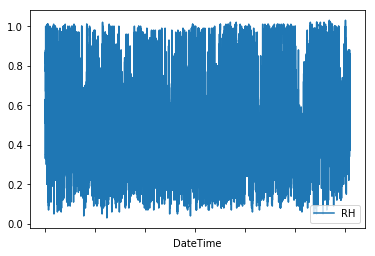

In [123]:
%matplotlib inline
p = data_rh.plot(x = 'DateTime', y = 'RH')
#plt.plot("time", "sat_value")
#plt.show()

In [124]:
#check if there are any missing values 
data_rh['AirTemp_C'].isnull().values.any()

False

In [125]:
#convert air T from C to K 
data_rh['AirTemp_K'] = data_rh['AirTemp_C']+273.15

In [126]:
Mw=18.0160 # molecular weight of water
Md=28.9660 # molecular weight of dry air
R =  8.31432E3 # gas constant
Rd = R/Md # specific gas constant for dry air
Rv = R/Mw # specific gas constant for vapour
Lv = 2.5e6 # heat release for condensation of water vapour [J kg-1]
eps = Mw/Md
#saturation pressure
def esat(T):
    ''' get sateration pressure (units [Pa]) for a given air temperature (units [K])'''
    from numpy import log10
    TK = 273.15
    e1 = 101325.0
    logTTK = log10(T/TK)
    esat =  e1*10**(10.79586*(1-TK/T)-5.02808*logTTK+ 1.50474*1e-4*(1.-10**(-8.29692*(T/TK-1)))+ 0.42873*1e-3*(10**(4.76955*(1-TK/T))-1)-2.2195983) 
    return esat
def esat2(T):
    ''' a simpler form for the saturation pressure (units [Pa]) for a given air temperature (units [K]), based on clausius-claperyon'''
    return 611.*exp(-Lv/Rv*(1./T - 1./273.16))

def rh2mixr(RH,p,T):
    '''purpose: conversion relative humidity (unitless) to mixing ratio [kg/kg]'''
    es = esat(T)
    return Mw/Md*RH*es/(p-RH*es)

def mixr2rh(mixr,p,T):
    '''purpose: conversion mixing ratio to relative humidity [kg/kg] (not tested)'''
    return mixr * p/((mixr+Mw/Md)*esat(T))

def mixr2sh(W):
    '''conversion from mixing ratio (units [kg/kg]) to specific humidity (units also [kg/kg])
    '''
    return W/(1.+W)

def calc_vap_pre(RH,es):
    return (RH * es)/100 

def specific_humidity(vapor_pressure, air_pressure):
    mix_rat = (eps * vapor_pressure) / (air_pressure - vapor_pressure)
    return mix_rat / (1 + mix_rat)

In [127]:
data_rh['esat'] = data_rh['AirTemp_K'].apply(esat)

In [128]:
data_rh

,DateTime,AirTemp_C,AirTemp_C_src,RH,RH_src,SnowDepth_cm,SnowDepth_src,SWE_cm,SWE_src,AirTemp_K,esat
0,10/1/10 0:00,9.7,C2998 regression,0.51,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,282.85,1203.425158
1,10/1/10 1:00,8.3,C2998 regression,0.54,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,281.45,1094.850191
2,10/1/10 2:00,7.4,C2998 regression,0.56,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.55,1029.702208
3,10/1/10 3:00,7.4,C2998 regression,0.57,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.55,1029.702208
4,10/1/10 4:00,7.1,C2998 regression,0.59,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.25,1008.759605
5,10/1/10 5:00,6.2,C2998 regression,0.61,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,279.35,948.169429
6,10/1/10 6:00,5.6,C2998 regression,0.62,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,278.75,909.583365
7,10/1/10 7:00,5.6,C2998 regression,0.63,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,278.75,909.583365
8,10/1/10 8:00,8.0,C2998 regression,0.61,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,281.15,1072.741492
9,10/1/10 9:00,13.9,C2998 regression,0.39,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,287.05,1588.182548


In [129]:

data_rh['vap_pres'] = data_rh.apply(lambda row: calc_vap_pre(row['RH'], row['esat']), axis=1)
data_rh = data_rh.join(data_air_p[['AirPressure_mb']])
data_rh['spec_hum'] = data_rh.apply(lambda row: specific_humidity(row['vap_pres'], row['AirPressure_mb']), axis=1)

In [130]:
data_rh

,DateTime,AirTemp_C,AirTemp_C_src,RH,RH_src,SnowDepth_cm,SnowDepth_src,SWE_cm,SWE_src,AirTemp_K,esat,vap_pres,AirPressure_mb,spec_hum
0,10/1/10 0:00,9.7,C2998 regression,0.51,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,282.85,1203.425158,6.137468,720.0,0.005319
1,10/1/10 1:00,8.3,C2998 regression,0.54,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,281.45,1094.850191,5.912191,720.0,0.005123
2,10/1/10 2:00,7.4,C2998 regression,0.56,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.55,1029.702208,5.766332,720.0,0.004996
3,10/1/10 3:00,7.4,C2998 regression,0.57,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.55,1029.702208,5.869303,720.0,0.005086
4,10/1/10 4:00,7.1,C2998 regression,0.59,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,280.25,1008.759605,5.951682,720.0,0.005157
5,10/1/10 5:00,6.2,C2998 regression,0.61,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,279.35,948.169429,5.783834,720.3,0.005009
6,10/1/10 6:00,5.6,C2998 regression,0.62,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,278.75,909.583365,5.639417,721.0,0.004879
7,10/1/10 7:00,5.6,C2998 regression,0.63,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,278.75,909.583365,5.730375,721.0,0.004958
8,10/1/10 8:00,8.0,C2998 regression,0.61,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,281.15,1072.741492,6.543723,721.8,0.005658
9,10/1/10 9:00,13.9,C2998 regression,0.39,C2998 regression,0.0,interpolated,NaN,pillow not yet installed,287.05,1588.182548,6.193912,722.0,0.005353
